# Model Training

### Data feed pipeline

In [1]:
import os
import random
import numpy as np
import cv2 as cv
import sys
import tensorflow as tf
print(f'Tensorflow version:{tf.__version__}')

import tqdm
import pathlib
import itertools
import collections

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from tensorflow_docs.vis import embed  #pip install -q git+https://github.com/tensorflow/docs

maxPowerLimit = 25 # Maximum power limit of the solar panel. If power exceeds this level it will be capped

2023-01-13 14:25:36.812814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 14:25:36.941575: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/anuradha/anaconda3/envs/tfcpu/lib/python3.9/site-packages/cv2/../../../../lib:
2023-01-13 14:25:36.941588: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-13 14:25:37.421477: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libn

Tensorflow version:2.11.0


In [2]:
# tf.config.threading.set_intra_op_parallelism_threads(2)
# print(tf.test.is_built_with_cuda())
# tf.config.list_physical_devices('GPU')

In [3]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [4]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv.VideoCapture(str(video_path))  

  video_length = src.get(cv.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [23]:
sample_video_path = './Videos/2/2_0025.avi'
sample_video = frames_from_video_file(sample_video_path, n_frames = 18)
sample_video.shape

(18, 224, 224, 3)

In [24]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


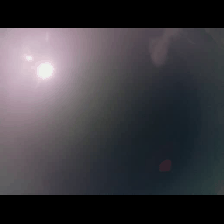

In [25]:
to_gif(sample_video)

In [8]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [9]:
train_path = pathlib.Path('./SplitDataset/train')
test_path = pathlib.Path('./SplitDataset/test')
val_path = pathlib.Path('./SplitDataset/validate')

fg = FrameGenerator(train_path, 10, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

2023-01-13 12:48:21.001431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shape: (10, 224, 224, 3)
Label: 2


In [10]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32), tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_path, 10, training=True),output_signature = output_signature)

In [11]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)


In [12]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(val_path, 10),output_signature = output_signature)

In [13]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [15]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

2023-01-13 12:48:33.208806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 513 of 1000
2023-01-13 12:48:42.658936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-01-13 12:48:42.719989: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)


2023-01-13 12:48:52.848841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 494 of 1000


Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validation labels: (2,)


2023-01-13 12:49:02.807685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-01-13 12:49:02.849292: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [17]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(10),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

model.fit(train_ds, 
          epochs = 10,
          validation_data = val_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))

Epoch 1/10
    131/Unknown - 40s 257ms/step - loss: 1.1900 - accuracy: 0.3321

2023-01-13 12:50:50.029708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 499 of 1000
2023-01-13 12:51:00.028303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 994 of 1000
2023-01-13 12:51:00.147469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


131/131 [==============================] - 338s 3s/step - loss: 1.1900 - accuracy: 0.3321 - val_loss: 1.0953 - val_accuracy: 0.3820
Epoch 2/10
131/131 [==============================] - 301s 2s/step - loss: 1.0955 - accuracy: 0.3893 - val_loss: 1.0990 - val_accuracy: 0.3333
Epoch 3/10
131/131 [==============================] - 302s 2s/step - loss: 1.0245 - accuracy: 0.4618 - val_loss: 0.9861 - val_accuracy: 0.5535
Epoch 4/10
131/131 [==============================] - 284s 2s/step - loss: 0.9988 - accuracy: 0.5344 - val_loss: 1.1748 - val_accuracy: 0.3424
Epoch 5/10
131/131 [==============================] - 283s 2s/step - loss: 0.9771 - accuracy: 0.5420 - val_loss: 1.0151 - val_accuracy: 0.3541
